In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
female = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/female', transform=transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))
male = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/male', transform=transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))
malestaff = torchvision.datasets.ImageFolder('/content/drive/My Drive/faces94/malestaff', transform=transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]))

In [ ]:
Dataloader = [torch.utils.data.DataLoader(female, batch_size=128, shuffle=True, num_workers=2), 
              torch.utils.data.DataLoader(male, batch_size=128, shuffle=True, num_workers=2), 
              torch.utils.data.DataLoader(malestaff, batch_size=128, shuffle=True, num_workers=2)] 

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

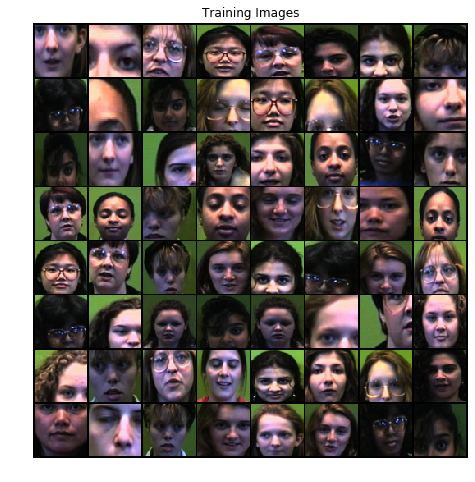

In [ ]:
real_batch = next(iter(Dataloader[0]))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [ ]:
def initialize_weights(arg_class):
  class_name = arg_class.__class__.__name__
  if class_name.find('Conv') != -1:
    torch.nn.init.normal_(arg_class.weight.data, 0.0, 0.02)
  elif class_name.find('BatchNorm') != -1:
    torch.nn.init.normal_(arg_class.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(arg_class.bias.data, 0)

In [ ]:
class Generator(torch.nn.Module):
  def __init__(self, feature_maps):
    super(Generator, self).__init__()
    self.feature_maps = feature_maps
    self.main = torch.nn.Sequential(torch.nn.ConvTranspose2d(100, feature_maps*8, 4, 1, 0, bias=False),
                                   torch.nn.BatchNorm2d(feature_maps*8),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(feature_maps*8, feature_maps*4, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(feature_maps*4),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(feature_maps*4, feature_maps*2, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(feature_maps*2),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(feature_maps*2, feature_maps, 4, 2, 1, bias=False),
                                   torch.nn.BatchNorm2d(feature_maps),
                                   torch.nn.ReLU(True),
                                   torch.nn.ConvTranspose2d(feature_maps, 3, 4, 2, 1, bias=False),
                                   torch.nn.Tanh()
                                   )
  def forward(self, input_vector):
    return self.main(input_vector)

class Discriminator(torch.nn.Module):
  def __init__(self, feature_maps):
    super(Discriminator, self).__init__()
    self.feature_maps = feature_maps
    self.main = torch.nn.Sequential(torch.nn.Conv2d(3, feature_maps, 4, 2, 1, bias = False),
                                   torch.nn.LeakyReLU(0.2, inplace=True),
                                   torch.nn.Conv2d(feature_maps, feature_maps*2, 4, 2, 1, bias = False),
                                   torch.nn.BatchNorm2d(feature_maps*2),
                                   torch.nn.LeakyReLU(0.2, inplace=True),
                                   torch.nn.Conv2d(feature_maps*2, feature_maps*4, 4, 2, 1, bias = False),
                                   torch.nn.BatchNorm2d(feature_maps*4),
                                   torch.nn.LeakyReLU(0.2, inplace=True),
                                   torch.nn.Conv2d(feature_maps*4, feature_maps*8, 4, 2, 1, bias = False),
                                   torch.nn.BatchNorm2d(feature_maps*8),
                                   torch.nn.LeakyReLU(0.2, inplace=True),
                                   torch.nn.Conv2d(feature_maps*8, 3, 4, 1, 0, bias = False),
                                   torch.nn.Sigmoid())
  def forward(self, input_image):
    return self.main(input_image)

In [ ]:
generator = Generator(64).to(device)
generator.apply(initialize_weights)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
discriminator = Discriminator(64).to(device)
discriminator.apply(initialize_weights)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 3, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
loss = torch.nn.BCELoss()
test_noise = torch.randn(64, 100, 1, 1, device = device)

In [ ]:
fake = 0
real = 1
generatorOptimizer = torch.optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
discriminatorOptimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:
img_list = []
generator_losses = []
discriminator_losses = []
iterations = 0
for epoch in range(250):
  for j in range(len(Dataloader)):
    for i, data in enumerate(Dataloader[j], 0):
      discriminator.zero_grad()
      batch = data[0].to(device)
      batch_size = batch.size(0)
      label = torch.full((batch_size*3, ), real, device=device)
      discriminator_output = discriminator(batch).view(-1)
      real_error = loss(discriminator_output, label)
      real_error.backward()
      dx = discriminator_output.mean().item()
      latent_noise = torch.randn(batch_size, 100, 1, 1, device = device)
      fake_image = generator(latent_noise)
      label.fill_(fake)
      generator_output = discriminator(fake_image.detach()).view(-1)
      fake_error = loss(generator_output, label)
      fake_error.backward()
      DGx = generator_output.mean().item()
      total_error = real_error + fake_error
      discriminatorOptimizer.step()
      generator.zero_grad()
      label.fill_(real)
      previous_output = discriminator(fake_image).view(-1)
      generator_error = loss(previous_output, label)
      generator_error.backward()
      Gx = previous_output.mean().item()
      generatorOptimizer.step()
      generator_losses.append(generator_error.item())
      discriminator_losses.append(total_error.item())
      if(iterations%10 == 0):
        print("EPOCH:", epoch)
        print("GENERATOR LOSS:", generator_error.item())
        print("DISCRIMINATOR LOSS:", total_error.item())
      if(iterations%50 == 0):
        with torch.no_grad():
          img_list.append(torchvision.utils.make_grid(generator(test_noise).detach().cpu(), padding=True, normalize=True))
      iterations += 1
      print("EPOCH:", epoch, "DATALOADER:", j, "BATCH:",i)

EPOCH: 0
GENERATOR LOSS: 3.2747180461883545
DISCRIMINATOR LOSS: 1.8283276557922363
EPOCH: 0 DATALOADER: 0 BATCH: 0
EPOCH: 0 DATALOADER: 0 BATCH: 1
EPOCH: 0 DATALOADER: 0 BATCH: 2
EPOCH: 0 DATALOADER: 0 BATCH: 3
EPOCH: 0 DATALOADER: 1 BATCH: 0
EPOCH: 0 DATALOADER: 1 BATCH: 1
EPOCH: 0 DATALOADER: 1 BATCH: 2
EPOCH: 0 DATALOADER: 1 BATCH: 3
EPOCH: 0 DATALOADER: 1 BATCH: 4
EPOCH: 0 DATALOADER: 1 BATCH: 5
EPOCH: 0
GENERATOR LOSS: 6.623487949371338
DISCRIMINATOR LOSS: 0.477813184261322
EPOCH: 0 DATALOADER: 1 BATCH: 6
EPOCH: 0 DATALOADER: 1 BATCH: 7
EPOCH: 0 DATALOADER: 1 BATCH: 8
EPOCH: 0 DATALOADER: 1 BATCH: 9
EPOCH: 0 DATALOADER: 1 BATCH: 10
EPOCH: 0 DATALOADER: 1 BATCH: 11
EPOCH: 0 DATALOADER: 1 BATCH: 12
EPOCH: 0 DATALOADER: 1 BATCH: 13
EPOCH: 0 DATALOADER: 1 BATCH: 14
EPOCH: 0 DATALOADER: 1 BATCH: 15
EPOCH: 0
GENERATOR LOSS: 9.9647855758667
DISCRIMINATOR LOSS: 0.44571903347969055
EPOCH: 0 DATALOADER: 1 BATCH: 16
EPOCH: 0 DATALOADER: 1 BATCH: 17
EPOCH: 0 DATALOADER: 2 BATCH: 0
EPOCH: 0 DA

In [ ]:
print(img_list[-1].size())

torch.Size([3, 521, 521])


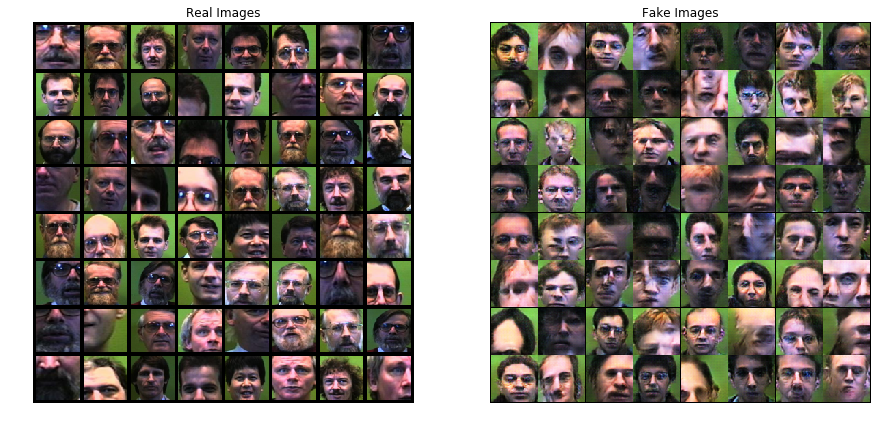

In [ ]:
real_batch = next(iter(Dataloader[2]))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()